In [ ]:
!pip install torch torchvision

In [1]:
import os
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

from torchvision import datasets
import torchvision.transforms as transforms
from tqdm import tqdm

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
a = torch.Tensor([1]).to(device)
print(a)

tensor([1.])


# Set up Neural Network (Resnet18)

In [3]:
class PreTrainedResNet(nn.Module):
    def __init__(self, num_classes, feature_extracting):
        super(PreTrainedResNet, self).__init__()
        
        # Load pre-trained ResNet Model
        self.resnet18 = models.resnet18(pretrained=True)

        # Set gradients to false
        if feature_extracting:
            for param in self.resnet18.parameters():
                param.requires_grad = False
    
        # Replace last fc layer
        num_feats = self.resnet18.fc.in_features
        
        # Replace fc layer in resnet to a linear layer of size (num_feats, num_classes)
        self.resnet18.fc = nn.Sequential(
            nn.Linear(num_feats, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, num_classes)
        ) 

    def forward(self, x):
        # Forward pass x through the model
        x = self.resnet18(x)
        return x

# Load Data

In [4]:
# Hyperparams
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
BATCH_SIZE = 32
RESNET_LAST_ONLY = True # Set to True to tune only the last layer. Set to False to tune entire network
AUGMENTATION = True # Choose whether using data augmentation

In [5]:
root_path = 'data/'

if AUGMENTATION == True:
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0,0,0], std=[1,1,1])
        ]),
        'validation': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0,0,0], std=[1,1,1])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0,0,0], std=[1,1,1])
        ]),
    }
else:
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ]),
        'validation': transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ]),
        'test': transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ]),
    }

# Load datasets with PyTorch ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(root_path, x), data_transforms[x]) for x in ['train', 'test','validation']}

# Define data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,shuffle=True, num_workers=4) for x in ['train', 'test', 'validation']}

# Define sizes of datasets, the number of labels
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test', 'validation']}
label_list = image_datasets['train'].classes
TOTAL_CLASSES = len(label_list)

# Initialize the model
model = PreTrainedResNet(len(label_list), RESNET_LAST_ONLY)
model = model.to(device)

# Set the optimizer, scheduler and loss criterion
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.5)
criterion = nn.CrossEntropyLoss()


# Evaluation on Validation Data

In [6]:
# Evaluation Reference: https://www.jianshu.com/p/f4952822e0e5
def validation(valloader, TOTAL_CLASSES):
    correct = 0
    total = 0

    class_correct = list(0. for i in range(TOTAL_CLASSES))
    class_total = list(0. for i in range(TOTAL_CLASSES))
    confusion_matrix = torch.zeros(TOTAL_CLASSES, TOTAL_CLASSES)

    for images, labels in valloader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model.forward(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum()

        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i]
            class_total[label] += 1
            
        for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

    #print("Confusion Matrix: ",confusion_matrix)

    # Get the per-class precision
    precision = confusion_matrix.diag()/confusion_matrix.sum(1)
    print("Precision: ", confusion_matrix.diag()/confusion_matrix.sum(1))
    
    # Get the per-class recall
    recall = confusion_matrix.diag()/confusion_matrix.sum(1)
    print("Recall: ", confusion_matrix.diag()/confusion_matrix.sum(0))
    
    # Get the per-class f1 score
    f1 = 2 * precision * recall / (precision + recall)
    print("F1 Score: ", f1)

    class_accuracy = np.divide(class_correct, class_total)
    return correct/total, class_accuracy

# Train model

In [7]:
train_loss_over_epochs = []
train_accuracy_over_epochs = []
val_accuracy_over_epochs = []
# Train
for epoch in tqdm(range(NUM_EPOCHS)):
    model.train()
    epoch_loss = 0.0
    epoch_acc = 0.0

    for batch_idx, (images, labels) in enumerate(dataloaders['train']):

        optimizer.zero_grad()

        images, labels = images.to(device), labels.to(device)
        # Forward
        outputs = model.forward(images)
        # Get current loss
        loss = criterion(outputs, labels)
        # Prediction
        _, preds = torch.max(outputs.data, 1)
        
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += torch.sum(preds == labels).item()
    
    epoch_loss /= dataset_sizes['train']
    epoch_acc /= dataset_sizes['train']
    
    train_loss_over_epochs.append(epoch_loss)
    train_accuracy_over_epochs.append(epoch_acc)
    
    print('Epoch %d/%d : Train Loss %.4f; Train Accuracy %.4f' % (epoch+1, NUM_EPOCHS, epoch_loss, epoch_acc))
    # Print evaluation on validation data
    val_accuracy, val_classwise_accuracy = validation(dataloaders['validation'], TOTAL_CLASSES)
    print('Validation Accuracy: %.4f' % (val_accuracy))

    # Print classwise accuracies
    for i in range(TOTAL_CLASSES):
        print('Accuracy of %5s : %.4f' % (label_list[i], val_classwise_accuracy[i]))
    print(" ")
    val_accuracy_over_epochs.append(val_accuracy)
    
    scheduler.step()
    
print("Finished Training")
print("---------------------------------------")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20 : Train Loss 0.0172; Train Accuracy 0.7204


  5%|▌         | 1/20 [02:46<52:44, 166.54s/it]

Precision:  tensor([0.8413, 0.8699])
Recall:  tensor([0.8867, 0.8191])
F1 Score:  tensor([0.8413, 0.8699])
Validation Accuracy: 0.8542
Accuracy of Araneae : 0.8413
Accuracy of Coleoptera : 0.8699
 
Epoch 2/20 : Train Loss 0.0120; Train Accuracy 0.8196


 10%|█         | 2/20 [05:33<49:59, 166.64s/it]

Precision:  tensor([0.8675, 0.8654])
Recall:  tensor([0.8863, 0.8437])
F1 Score:  tensor([0.8675, 0.8654])
Validation Accuracy: 0.8665
Accuracy of Araneae : 0.8675
Accuracy of Coleoptera : 0.8654
 
Epoch 3/20 : Train Loss 0.0109; Train Accuracy 0.8522


 15%|█▌        | 3/20 [08:21<47:19, 167.00s/it]

Precision:  tensor([0.8712, 0.8684])
Recall:  tensor([0.8890, 0.8479])
F1 Score:  tensor([0.8712, 0.8684])
Validation Accuracy: 0.8700
Accuracy of Araneae : 0.8712
Accuracy of Coleoptera : 0.8684
 
Epoch 4/20 : Train Loss 0.0107; Train Accuracy 0.8433


 20%|██        | 4/20 [11:07<44:30, 166.88s/it]

Precision:  tensor([0.8525, 0.9062])
Recall:  tensor([0.9167, 0.8354])
F1 Score:  tensor([0.8525, 0.9062])
Validation Accuracy: 0.8768
Accuracy of Araneae : 0.8525
Accuracy of Coleoptera : 0.9062
 
Epoch 5/20 : Train Loss 0.0098; Train Accuracy 0.8516


 25%|██▌       | 5/20 [13:53<41:37, 166.53s/it]

Precision:  tensor([0.8550, 0.8926])
Recall:  tensor([0.9060, 0.8357])
F1 Score:  tensor([0.8550, 0.8926])
Validation Accuracy: 0.8720
Accuracy of Araneae : 0.8550
Accuracy of Coleoptera : 0.8926
 
Epoch 6/20 : Train Loss 0.0096; Train Accuracy 0.8631


 30%|███       | 6/20 [16:39<38:50, 166.44s/it]

Precision:  tensor([0.8413, 0.9123])
Recall:  tensor([0.9207, 0.8260])
F1 Score:  tensor([0.8413, 0.9123])
Validation Accuracy: 0.8734
Accuracy of Araneae : 0.8413
Accuracy of Coleoptera : 0.9123
 
Epoch 7/20 : Train Loss 0.0093; Train Accuracy 0.8663


 35%|███▌      | 7/20 [19:26<36:04, 166.53s/it]

Precision:  tensor([0.9050, 0.8563])
Recall:  tensor([0.8840, 0.8816])
F1 Score:  tensor([0.9050, 0.8563])
Validation Accuracy: 0.8830
Accuracy of Araneae : 0.9050
Accuracy of Coleoptera : 0.8563
 
Epoch 8/20 : Train Loss 0.0093; Train Accuracy 0.8624


 40%|████      | 8/20 [22:12<33:16, 166.34s/it]

Precision:  tensor([0.8313, 0.9183])
Recall:  tensor([0.9249, 0.8181])
F1 Score:  tensor([0.8313, 0.9183])
Validation Accuracy: 0.8706
Accuracy of Araneae : 0.8313
Accuracy of Coleoptera : 0.9183
 
Epoch 9/20 : Train Loss 0.0093; Train Accuracy 0.8663


 45%|████▌     | 9/20 [24:58<30:28, 166.20s/it]

Precision:  tensor([0.8687, 0.8865])
Recall:  tensor([0.9026, 0.8480])
F1 Score:  tensor([0.8687, 0.8865])
Validation Accuracy: 0.8768
Accuracy of Araneae : 0.8688
Accuracy of Coleoptera : 0.8865
 
Epoch 10/20 : Train Loss 0.0083; Train Accuracy 0.8868


 50%|█████     | 10/20 [27:44<27:43, 166.33s/it]

Precision:  tensor([0.8838, 0.8714])
Recall:  tensor([0.8927, 0.8610])
F1 Score:  tensor([0.8838, 0.8714])
Validation Accuracy: 0.8782
Accuracy of Araneae : 0.8838
Accuracy of Coleoptera : 0.8714
 
Epoch 11/20 : Train Loss 0.0091; Train Accuracy 0.8663


 55%|█████▌    | 11/20 [30:30<24:55, 166.14s/it]

Precision:  tensor([0.8788, 0.8986])
Recall:  tensor([0.9130, 0.8596])
F1 Score:  tensor([0.8788, 0.8986])
Validation Accuracy: 0.8877
Accuracy of Araneae : 0.8788
Accuracy of Coleoptera : 0.8986
 
Epoch 12/20 : Train Loss 0.0084; Train Accuracy 0.8874


 60%|██████    | 12/20 [33:16<22:08, 166.06s/it]

Precision:  tensor([0.8950, 0.8820])
Recall:  tensor([0.9018, 0.8741])
F1 Score:  tensor([0.8950, 0.8820])
Validation Accuracy: 0.8891
Accuracy of Araneae : 0.8950
Accuracy of Coleoptera : 0.8820
 
Epoch 13/20 : Train Loss 0.0083; Train Accuracy 0.8842


 65%|██████▌   | 13/20 [36:03<19:25, 166.47s/it]

Precision:  tensor([0.8913, 0.8623])
Recall:  tensor([0.8868, 0.8676])
F1 Score:  tensor([0.8913, 0.8623])
Validation Accuracy: 0.8782
Accuracy of Araneae : 0.8912
Accuracy of Coleoptera : 0.8623
 
Epoch 14/20 : Train Loss 0.0084; Train Accuracy 0.8874


 70%|███████   | 14/20 [38:49<16:37, 166.20s/it]

Precision:  tensor([0.8625, 0.8759])
Recall:  tensor([0.8938, 0.8403])
F1 Score:  tensor([0.8625, 0.8759])
Validation Accuracy: 0.8686
Accuracy of Araneae : 0.8625
Accuracy of Coleoptera : 0.8759
 
Epoch 15/20 : Train Loss 0.0081; Train Accuracy 0.8810


 75%|███████▌  | 15/20 [41:34<13:49, 165.95s/it]

Precision:  tensor([0.8813, 0.8850])
Recall:  tensor([0.9027, 0.8603])
F1 Score:  tensor([0.8813, 0.8850])
Validation Accuracy: 0.8830
Accuracy of Araneae : 0.8812
Accuracy of Coleoptera : 0.8850
 
Epoch 16/20 : Train Loss 0.0086; Train Accuracy 0.8752


 80%|████████  | 16/20 [44:19<11:02, 165.61s/it]

Precision:  tensor([0.8763, 0.8926])
Recall:  tensor([0.9080, 0.8563])
F1 Score:  tensor([0.8763, 0.8926])
Validation Accuracy: 0.8836
Accuracy of Araneae : 0.8762
Accuracy of Coleoptera : 0.8926
 
Epoch 17/20 : Train Loss 0.0080; Train Accuracy 0.8964


 85%|████████▌ | 17/20 [47:04<08:16, 165.48s/it]

Precision:  tensor([0.8788, 0.9047])
Recall:  tensor([0.9178, 0.8604])
F1 Score:  tensor([0.8788, 0.9047])
Validation Accuracy: 0.8905
Accuracy of Araneae : 0.8788
Accuracy of Coleoptera : 0.9047
 
Epoch 18/20 : Train Loss 0.0085; Train Accuracy 0.8880


 90%|█████████ | 18/20 [49:51<05:31, 165.68s/it]

Precision:  tensor([0.8938, 0.8850])
Recall:  tensor([0.9039, 0.8731])
F1 Score:  tensor([0.8938, 0.8850])
Validation Accuracy: 0.8898
Accuracy of Araneae : 0.8938
Accuracy of Coleoptera : 0.8850
 
Epoch 19/20 : Train Loss 0.0080; Train Accuracy 0.8893


 95%|█████████▌| 19/20 [52:37<02:45, 165.88s/it]

Precision:  tensor([0.8650, 0.8880])
Recall:  tensor([0.9034, 0.8446])
F1 Score:  tensor([0.8650, 0.8880])
Validation Accuracy: 0.8754
Accuracy of Araneae : 0.8650
Accuracy of Coleoptera : 0.8880
 
Epoch 20/20 : Train Loss 0.0079; Train Accuracy 0.8989


100%|██████████| 20/20 [55:22<00:00, 166.15s/it]

Precision:  tensor([0.8662, 0.8835])
Recall:  tensor([0.9000, 0.8452])
F1 Score:  tensor([0.8662, 0.8835])
Validation Accuracy: 0.8741
Accuracy of Araneae : 0.8662
Accuracy of Coleoptera : 0.8835
 
Finished Training
---------------------------------------


# Plot Figures

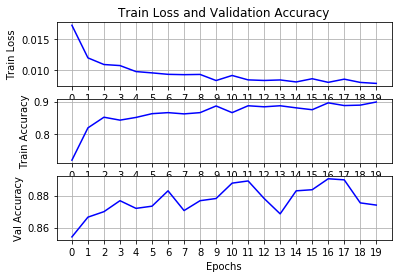

In [8]:
plt.ioff()
fig = plt.figure()

# Plot train loss over epochs and val set accuracy over epochs

plt.subplot(3, 1, 1)
plt.ylabel('Train Loss')
plt.plot(np.arange(NUM_EPOCHS), train_loss_over_epochs, 'b-')
plt.title('Train Loss and Validation Accuracy')
plt.xticks(np.arange(NUM_EPOCHS, dtype=int))
plt.grid(True)

plt.subplot(3, 1, 2)
plt.ylabel('Train Accuracy')
plt.plot(np.arange(NUM_EPOCHS), train_accuracy_over_epochs, 'b-')
plt.xticks(np.arange(NUM_EPOCHS, dtype=int))
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(np.arange(NUM_EPOCHS), val_accuracy_over_epochs, 'b-')
plt.ylabel('Val Accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(NUM_EPOCHS, dtype=int))
plt.grid(True)
plt.show()
plt.close(fig)

# Test

In [9]:
def test(model, criterion, repeats=2):
    model.eval()

    test_loss = 0.0
    test_acc = 0.0

    with torch.no_grad():
        for itr in range(repeats):
            for batch_idx, (images, labels) in enumerate(dataloaders['test']):
                images, labels = images.to(device), labels.to(device)

                # Forward
                outputs = model.forward(images)
                # Get loss
                loss = criterion(outputs, labels)
                # Prediction
                _, preds = torch.max(outputs.data, 1)

                test_loss += loss.item()
                test_acc += torch.sum(preds == labels).item()

        test_loss /= (dataset_sizes['test']*repeats)
        test_acc /= (dataset_sizes['test']*repeats)

        print('Test Loss: %.4f Test Accuracy %.4f' % (test_loss, test_acc))


In [10]:
test(model, criterion)

Test Loss: 0.0077 Test Accuracy 0.8896


# Visualization on Test Samples

In [11]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(1)  # Pause a bit so that plots are updated
    
def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()

    for batch_idx, (images, labels) in enumerate(dataloaders['test']):
        
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        
        _, preds = torch.max(outputs.data, 1)
       

        for j in range(images.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('True class: {}\n Predicted class: {}'.format(label_list[labels.data[j]], label_list[preds[j]]))

            imshow(images.cpu().data[j])

            if images_so_far == num_images:
                return

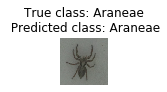

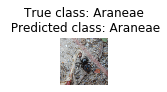

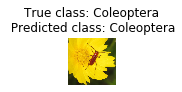

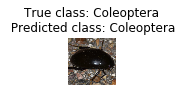

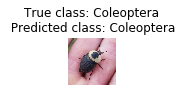

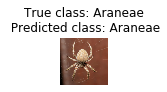

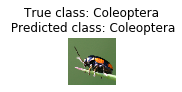

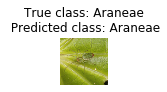

In [12]:
visualize_model(model)